In [16]:
# import h5py
# import numpy as np
# import sklearn.model_selection
import matplotlib.pyplot as plt
from isotree import IsolationForest
from scripts import physics, dataset
import numpy as np

In [4]:
x_train, x_test = dataset.create_xtrain_xtest()
nugun = dataset.load_dataset('NuGun_preprocessed.h5', 'full_data_cyl')
BB = dataset.load_dataset('BSM_preprocessed.h5', 'ttHto2B')

In [5]:
new_dataset, labels, _, _, _, _ = dataset.inject_signal(x_test, BB, size='max', percentage=0.01)
# new_dataset, labels, bkg, sig, size_bkg, size_sig

In [6]:
dijet_BB = physics.invariant_mass(BB, type='jet')
dijet_nugun = physics.invariant_mass(nugun, type='jet')

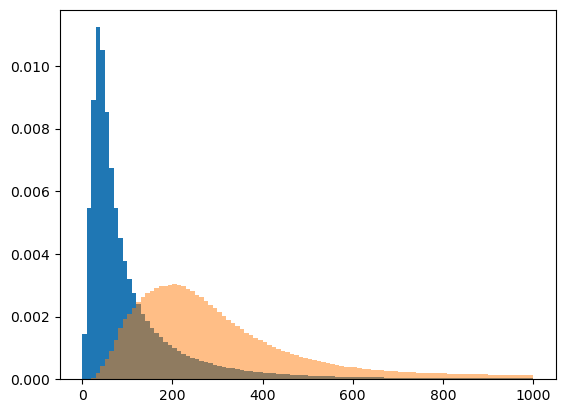

In [9]:
plt.hist(dijet_nugun, range=(0,1000), bins=100, density=True)
plt.hist(dijet_BB, range=(0,1000), bins=100, density=True, alpha=0.5)
pass

In [10]:
model = IsolationForest(ndim=3,ntrees=100).fit(x_train)
score = model.predict(new_dataset, output="score")

In [13]:
# this is s.t. we can compare it
score_bkg = model.predict(x_train, output="score")

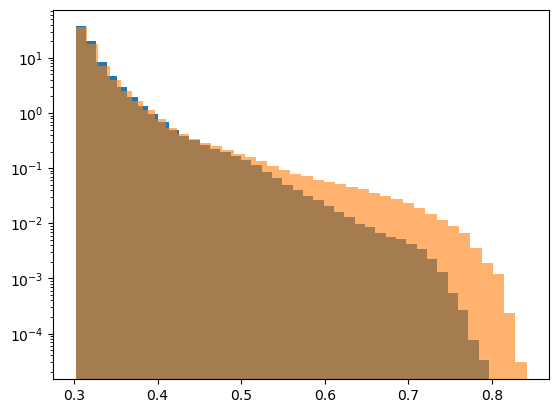

In [14]:
plt.hist(score_bkg, density=True, bins=40, log=True)
plt.hist(score, density=True, alpha=0.6, bins=40, log=True)
pass

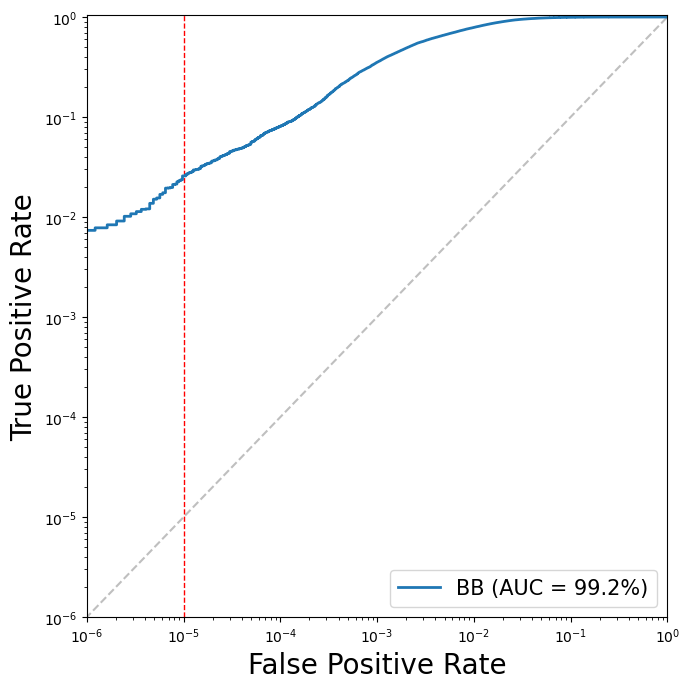

In [20]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7, 7))
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.xlim([10**-(6), 1.0])
plt.ylim([10**-(6), 1.05])
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.xlabel('False Positive Rate',fontsize=20) # bkg efficiency
plt.ylabel('True Positive Rate',fontsize=20) # sig efficiency
plt.semilogx()
plt.semilogy()

trueVal = labels
predVal_loss = score
fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
auc_loss = auc(fpr_loss, tpr_loss)

plt.plot(fpr_loss, tpr_loss, lw=2, label='BB (AUC = %.1f%%)' % (auc_loss * 100))

plt.legend(loc='lower right',fontsize=15)
plt.tight_layout()

In [ ]:
# ## for L1 rate estimates from ZeroBias/SingleNuMC
# def totalMinBiasRate(nCollBunch = 2500): 
#     LHCfreq = 11245.6
#     return LHCfreq * nCollBunch / 1e3 # in kHz

In [ ]:
# plt.plot(fpr_loss*totalMinBiasRate(), tpr_loss, lw=2, label='BB (AUC = %.1f%%)' % (auc_loss * 100))

# plt.xlabel("FPR*MBrate: Trigger rate [kHz]")
# plt.ylabel("TPR: signal efficiency")
# plt.grid()
# plt.xlim(0,100)

In [ ]:
# def get_sig(threshold, score, labels):
#     get_indices = [i for i in range(len(score)) if score[i] >= threshold]
#     total_event_count = len(labels[get_indices])
#     total_sig_count = np.sum(labels[get_indices])
#     return total_sig_count/np.sqrt(total_event_count)


# def anom_score_threshhold_scan(score, labels, step, start=np.min(score_bkg), end=np.max(score_bkg)):
#     scan_range = np.linspace(start, end, num=step)
#     significance = []

#     for i in scan_range:
#         significance.append(get_sig(i, score, labels))
#     return significance, scan_range


In [ ]:
# sb, scan_range = anom_score_threshhold_scan(score, b, step=200)

In [ ]:
# plt.plot(scan_range, sb)

In [ ]:
# scan_range[np.argmax(sb)]

In [ ]:
# sb[np.argmax(sb)]

In [ ]:
# plt.hist(score_bkg, density=True, bins=40, log=True, histtype='step')
# plt.hist(score, density=True, alpha=0.6, bins=40, log=True)
# plt.vlines(scan_range[np.argmax(sb)], 0,10, color='red')
# pass

In [ ]:
# score_len = len(score)
# get_indices_anom = [i for i in range(score_len) if score[i] >= scan_range[np.argmax(sb)]]
# get_indices_other = [i for i in range(score_len) if score[i] < scan_range[np.argmax(sb)]]

In [ ]:
# anom = a[get_indices_anom]
# other = a[get_indices_other]

In [ ]:
# dijet_anom = inv_mass_list(anom, 'jet')
# dijet_other = inv_mass_list(other, 'jet')

In [ ]:
# dijet_BB = inv_mass_list(BB, 'jet')

In [ ]:
# dijet = inv_mass_list(nugun, 'jet')

In [ ]:
# dijet_all = inv_mass_list(a, 'jet')

In [ ]:
# plt.hist(dijet_other, log=True, range=(0,1000), bins=100, density=True)
# plt.hist(dijet_all, log=True, range=(0,1000), bins=100, density=True, histtype='step')
# pass

In [ ]:
# plt.hist(dijet_other, log=True, range=(0,1000), bins=100, density=True)
# plt.hist(dijet, log=True, range=(0,1000), bins=100, density=True, histtype='step')
# pass

In [ ]:
# plt.hist(dijet_anom, log=True, range=(0,1000), bins=100, density=True)
# plt.hist(dijet_BB, log=True, range=(0,1000), bins=100, density=True, histtype='step')
# pass

In [ ]:
# plt.hist(dijet_BB, log=True, range=(0,1000), histtype='step', density=True, bins=100, bottom=plt.hist(dijet, histtype='step', range=(0,1000), bins=100, density=True)[0])
# plt.hist(dijet_anom, log=True, range=(0,1000), bins=100, density=True, histtype='step')
# pass
